# SYDE 556/750: Simulating Neurobiological Systems

Accompanying Readings: Chapter 6

## Transformation

- The story so far:
    - The activity of groups of neurons can represent variables $x$
    - $x$ can be an aribitrary-dimension vector
    - Each neuron has a preferred vector $e$
    - Current going into each neuron is $J = \alpha e \cdot x + J^{bias}$
    - We can interpret neural activity via $\hat{x}=\sum a_i d_i$
    - For spiking neurons, we filter the spikes first: $\hat{x}=\sum a_i(t)*h(t) d_i$
    - To compute $d$, generate some $x$ values and find the optimal $d$ (assuming some amount of noise)
    
- So far we've just talked about neural activity in a single population
- What about connections between neurons?

<img src="files/lecture4/communication1.png">


### Connecting neurons

- Up till now, we've always had the current going into a neuron be something we computed from $x$
    - $J = \alpha e \cdot x + J^{bias}$
- This will continue to be how we handle inputs
    - Sensory neurons, for example
    - Or whatever's coming from the rest of the brain that we're not modelling (yet)
- But what about other groups of neurons?
    - How do they end up getting the amount of input current that we're injecting with $J = \alpha e \cdot x + J^{bias}$ ?
    - Where does that current come from?
        - Inputs from neurons connected to this one
        - Through weighted synaptic connections
    - Let's think about neurons in a simple case

### A communication channel

- Let's say we have two groups of neurons
    - One group represents $x$
    - One group represents $y$
    - Can we pass the value from one group of neurons to the other?  
- Without worrying about biological plausibility to start, we can formulate this in two steps
    - Drive the first population $a$ with the input, $x$, then decoded it to give $\hat{x}$
    - Now use $y=\hat{x}$ to drive the 2nd population $b$, and then decode that
- Let's start by first constructing the two populations
    - Stimulate them both directly and decode to compare

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Simulation finished in 0:00:01.                                                 


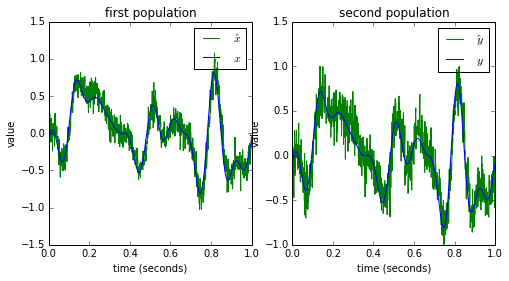

In [4]:
import numpy as np
import nengo
from nengo.dists import Uniform
from nengo.processes import WhiteSignal
from nengo.solvers import LstsqL2

T = 1.0
max_freq = 10

model = nengo.Network('Communication Channel', seed=3)

with model:
    stim = nengo.Node(output=WhiteSignal(T, high=max_freq, rms=0.5))
    ensA = nengo.Ensemble(20, dimensions=1, neuron_type=nengo.LIFRate())
    ensB = nengo.Ensemble(19, dimensions=1, neuron_type=nengo.LIFRate())
    temp = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.LIFRate())
    
    nengo.Connection(stim, ensA)
    stim_B = nengo.Connection(stim, ensB)
    
    connectionA = nengo.Connection(ensA, temp) #This is just to generate the decoders
    connectionB = nengo.Connection(ensB, temp) #This is just to generate the decoders
     
    stim_p = nengo.Probe(stim)
    a_rates = nengo.Probe(ensA.neurons, 'rates')
    b_rates = nengo.Probe(ensB.neurons, 'rates')
   
sim = nengo.Simulator(model, seed=3)
sim.run(T)

x = sim.data[stim_p]

d_i = sim.data[connectionA].weights.T
A_i = sim.data[a_rates]

d_j = sim.data[connectionB].weights.T
A_j = sim.data[b_rates]

#Add noise
A_i = A_i + np.random.normal(scale=0.2*np.max(A_i), size=A_i.shape)
A_j = A_j + np.random.normal(scale=0.2*np.max(A_j), size=A_j.shape)

xhat_i = np.dot(A_i, d_i)
yhat_j = np.dot(A_j, d_j)

t = sim.trange()
figure(figsize=(8,4))
subplot(1,2,1)
plot(t, xhat_i, 'g', label='$\hat{x}$')
plot(t, x, 'b', label='$x$')
legend()
xlabel('time (seconds)')
ylabel('value')
title('first population')

subplot(1,2,2)
plot(t, yhat_j, 'g', label='$\hat{y}$')
plot(t, x, 'b', label='$y$')
legend()
xlabel('time (seconds)')
ylabel('value')
title('second population');

- So everything works fine if we drive each population with the same $x$, let's switch to $\hat{x}$ in the middle

Simulation finished in 0:00:01.                                                 


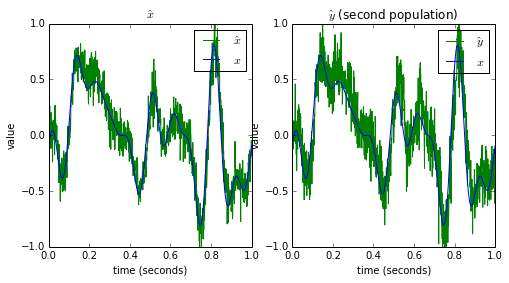

In [5]:
#Have to run previous cells first
model.connections.remove(stim_B)
del stim_B

def xhat_fcn(t):
    idx = int(t/sim.dt)
    if idx>=1000: idx=999
    return xhat_i[idx]

with model:
    xhat = nengo.Node(xhat_fcn)
    
    nengo.Connection(xhat, ensB)
    
    xhat_p = nengo.Probe(xhat)
    
sim = nengo.Simulator(model, seed=3)
sim.run(T)

d_j = sim.data[connectionB].weights.T
A_j = sim.data[b_rates]

A_j = A_j + numpy.random.normal(scale=0.2*numpy.max(A_j), size=A_j.shape)

yhat_j = numpy.dot(A_j, d_j)

t = sim.trange()
figure(figsize=(8,4))
subplot(1,2,1)
plot(t, xhat_i, 'g', label='$\hat{x}$')
plot(t, x, 'b', label='$x$')
legend()
xlabel('time (seconds)')
ylabel('value')
title('$\hat{x}$')
ylim(-1,1)

subplot(1,2,2)
plot(t, yhat_j, 'g', label='$\hat{y}$')
plot(t, x, 'b', label='$x$')
legend()
xlabel('time (seconds)')
ylabel('value')
title('$\hat{y}$ (second population)')
ylim(-1,1);

- Looks pretty much the same! (just delayed, maybe)
- So now we've passed one value to the other, but it's implausible
    - The brain doesn't decode and then re-encode
    - Can we skip those steps?  Or combine them?

### A shortcut

- Let's write down what we've done:
    - Encode into $a$: $a_i = G_i[\alpha_i e_i x + J^{bias}_i]$
    - Decode from $a$: $\hat{x} = \sum_i a_i d_i$
    - Set $y = \hat{x}$
    - Encode into $b$: $b_j = G_j[\alpha_j e_j y + J^{bias}_j]$
    - Decode from $b$: $\hat{y} = \sum_j b_j d_j$

- Now let's just do the substitutions:
    - I.e. substitute $y = \hat{x} = \sum_i a_i d_i$ into $b$
    - $b_j = G_j[\alpha_j e_j \sum_i a_i d_i + J^{bias}_j]$
    - $b_j = G_j[\sum_i \alpha_j e_j d_i a_i  + J^{bias}_j]$
    - $b_j = G_j[\sum_i \omega_{ij}a_i + J^{bias}_j]$
    - where $\omega_{ij} = \alpha_j e_j \cdot d_i$ (an outer product)    
    
- In other words, we can get the entire weight matrix just by multiplying the decoders from the first population with the encoders from the second population

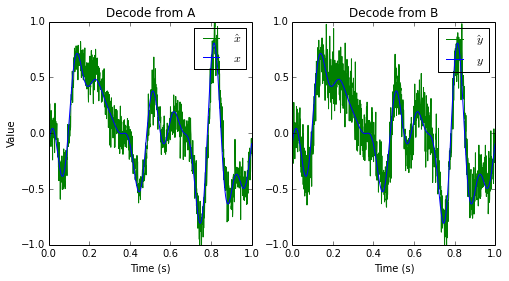

In [6]:
#Have to run previous cells first
n = nengo.neurons.LIFRate()

alpha_j = sim.data[ensB].gain
bias_j = sim.data[ensB].bias
encoders_j = sim.data[ensB].encoders.T

connection_weights = np.outer(alpha_j*encoders_j, d_i)

J_j = np.dot(connection_weights, sim.data[a_rates].T).T + bias_j

A_j = n.rates(J_j, gain=1, bias=0) #Gain and bias already in the previous line

A_j = A_j + numpy.random.normal(scale=0.2*numpy.max(A_j), size=A_j.shape)

xhat_j = numpy.dot(A_j, d_j)

figure(figsize=(8,4))
subplot(1,2,1)
plot(t, xhat_i, 'g', label='$\hat{x}$')
plot(t, x, 'b', label='$x$')
legend()
xlabel('Time (s)')
ylabel('Value')
title('Decode from A')
ylim(-1,1)

subplot(1,2,2)
plot(t, xhat_j, 'g', label='$\hat{y}$')
plot(t, x, 'b', label='$y$')
legend()
xlabel('Time (s)')
title('Decode from B');
ylim(-1,1);

- In fact, instead of computing $\omega_{ij}$ at all, it is (usually) more efficient to just do the encoding/decoding
    - Saves a lot of memory space, since you don't have to store a giant weight matrix
    - Also, you have NxM multiplies for weights, but only do ~N+M multiplies for encode/decode
    

In [7]:
J_j = numpy.outer(numpy.dot(A_i, d_i), alpha_j*encoders_j)+bias_j

- This means we get the exact same effect as having a weight matrix $\omega_{ij}$ if we just take the decoded value from one population and feed that into the next population using the normal encoding method
    - These are numerically identical processes, since $\omega_{ij} = \alpha_j e_j \cdot d_i$

### Spiking neurons

- The same approach works for spiking neurons
    - Do exactly the same as before
    - The $a_i(t)$ values are spikes, and we convolve with $h(t)$
    

## Other transformations

- So this lets us take an $x$ value and feed it into another population
    - Passing information from one group of neurons to the next
    - We call this a 'Communication Channel' as you're just sending the information
- What about transforming that information in some way?
    - Instead of $y=x$, can we do $y=f(x)$?
- Let's try $y=2x$ to start
- We already have a decoder for $\hat{x}$, so how do we get a decoder for $\hat{2x}$?
    - Two ways
        - Either use $2x$ when computing $\Upsilon$
        - Or just multiply your 'representational' decoder by $2$

Simulation finished in 0:00:01.                                                 


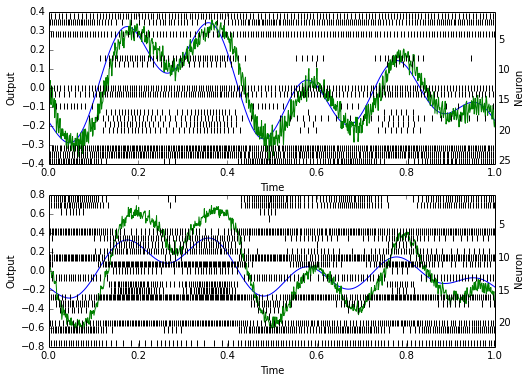

In [8]:
import nengo
from nengo.processes import WhiteNoise
from nengo.utils.matplotlib import rasterplot

T = 1.0
max_freq = 5

model = nengo.Network()

with model:
    stim = nengo.Node(output=WhiteSignal(T, high=max_freq, rms=0.3))
    ensA = nengo.Ensemble(25, dimensions=1)
    ensB = nengo.Ensemble(23, dimensions=1)
    
    nengo.Connection(stim, ensA)
    nengo.Connection(ensA, ensB, transform=2) #function=lambda x: 2*x)
    
    stim_p = nengo.Probe(stim)
    ensA_p = nengo.Probe(ensA, synapse=.01)
    ensB_p = nengo.Probe(ensB, synapse=.01)
    ensA_spikes_p = nengo.Probe(ensA.neurons, 'spikes')
    ensB_spikes_p = nengo.Probe(ensB.neurons, 'spikes')
   
sim = nengo.Simulator(model, seed=4)
sim.run(T)

t = sim.trange()
figure(figsize=(8, 6))
subplot(2,1,1)
ax = gca()
plot(t, sim.data[stim_p],'b')
plot(t, sim.data[ensA_p],'g')
ylabel("Output")
xlabel("Time");
rasterplot(t, sim.data[ensA_spikes_p], ax=ax.twinx(), color='k', use_eventplot=True)
#axis('tight')
ylabel("Neuron")

subplot(2,1,2)
ax = gca()
plot(t, sim.data[stim_p],'b')
plot(t, sim.data[ensB_p],'g')
ylabel("Output")
xlabel("Time");
rasterplot(t, sim.data[ensB_spikes_p], ax=ax.twinx(), color='k', use_eventplot=True)
#axis('tight')
ylabel("Neuron");

- What about a nonlinear function?
    - $y = x^2$
    
    

Simulation finished in 0:00:01.                                                 


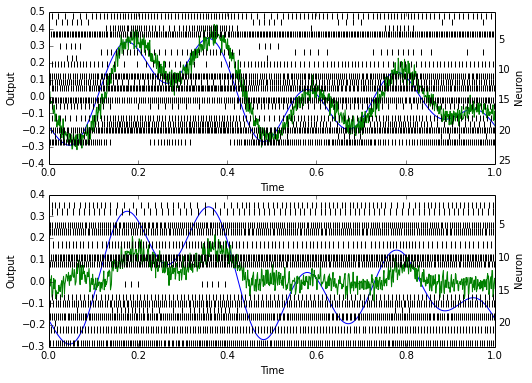

In [9]:
import nengo
from nengo.processes import WhiteNoise
from nengo.utils.matplotlib import rasterplot

T = 1.0
max_freq = 5

model = nengo.Network()

with model:
    stim = nengo.Node(output=WhiteSignal(T, high=max_freq, rms=0.3))
    ensA = nengo.Ensemble(25, dimensions=1)
    ensB = nengo.Ensemble(23, dimensions=1)
    
    nengo.Connection(stim, ensA)
    nengo.Connection(ensA, ensB, function=lambda x: x**2)
    
    stim_p = nengo.Probe(stim)
    ensA_p = nengo.Probe(ensA, synapse=.01)
    ensB_p = nengo.Probe(ensB, synapse=.01)
    ensA_spikes_p = nengo.Probe(ensA.neurons, 'spikes')
    ensB_spikes_p = nengo.Probe(ensB.neurons, 'spikes')
   
sim = nengo.Simulator(model, seed=4)
sim.run(T)

t = sim.trange()
figure(figsize=(8, 6))
subplot(2,1,1)
ax = gca()
plot(t, sim.data[stim_p],'b')
plot(t, sim.data[ensA_p],'g')
ylabel("Output")
xlabel("Time");
rasterplot(t, sim.data[ensA_spikes_p], ax=ax.twinx(), color='k', use_eventplot=True)
#axis('tight')
ylabel("Neuron")

subplot(2,1,2)
ax = gca()
plot(t, sim.data[stim_p],'b')
plot(t, sim.data[ensB_p],'g')
ylabel("Output")
xlabel("Time");
rasterplot(t, sim.data[ensB_spikes_p], ax=ax.twinx(), color='k', use_eventplot=True)
#axis('tight')
ylabel("Neuron");

- When you set the connection 'function' in Nengo, it solves the same decoding equation as before, but for a function.
- In equations:
    - $ d^{f(x)} = \Gamma^{-1} \Upsilon^{f(x)} $
    - $ \Upsilon_i^{f(x)} = \sum_x a_i f(x) \;dx$
    - $ \Gamma_{ij} = \sum_x a_i a_j \;dx $
    - $ \hat{f}(x) =\sum_i a_i d_i^{f(x)}$

- In code:

In [ ]:
f_x = my_function(x)

gamma=np.dot(A.T,A)
upsilon_f=np.dot(A.T,f_x)
d_f = np.dot(np.linalg.pinv(gamma),upsilon)

xhat = np.dot(A, d_f)

- We call standard $d_i$ "representational decoders"
- We call $d_i^{f(x)}$ "transformational decoders" (or "decoders for $f(x)$")

### Adding

- What if we want to combine the inputs from two different populations?
    - Linear case: $z=x+y$

<img src="files/lecture4/adding1.png">


- We want the total current going into a $z$ neuron to be $J=\alpha e \cdot (x+y) + J^{bias}$
- How can we achieve this?
- Again, substitute into the equation, where $z = x+y \approx \hat{x}+\hat{y}$
    - $J_k=\alpha_k e \cdot (\hat{x}+\hat{y}) + J_k^{bias}$
    - $\hat{x} = \sum_i a_i d_i$
    - $\hat{y} = \sum_j a_j d_j$
    - $J_k=\alpha_k e_k \cdot (\sum_i a_i d_i+\sum_j a_j d_j) + J_k^{bias}$
    - $J_k=\sum_i(\alpha_k e_k \cdot d_i a_i) + \sum_j(\alpha_k e_k \cdot d_j a_j) + J_k^{bias}$
    - $J_k=\sum_i(\omega_{ik} a_i) + \sum_j(\omega_{jk} a_j) + J_k^{bias}$
    - $\omega_{ik}=\alpha_k e_k \cdot d_i$ and $\omega_{jk}=\alpha_k e_k \cdot d_j$ 
- Putting multiple inputs into a neuron automatically gives us addition!

Simulation finished in 0:00:01.                                                 


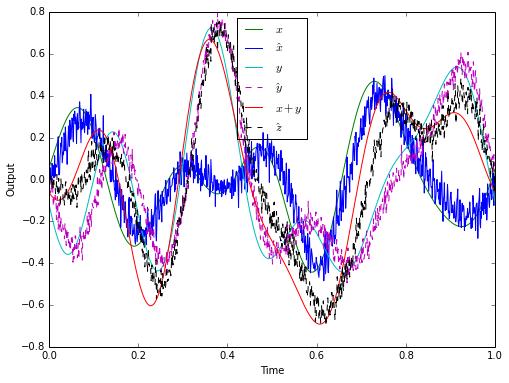

In [10]:
import nengo
from nengo.processes import WhiteNoise
from nengo.utils.matplotlib import rasterplot

T = 1.0
max_freq = 5

model = nengo.Network()

with model:
    stimA = nengo.Node(output=WhiteSignal(T, high=max_freq, rms=0.3, seed=3))
    stimB = nengo.Node(output=WhiteSignal(T, high=max_freq, rms=0.3, seed=5))
    
    ensA = nengo.Ensemble(25, dimensions=1)
    ensB = nengo.Ensemble(23, dimensions=1)
    ensC = nengo.Ensemble(24, dimensions=1)
    
    nengo.Connection(stimA, ensA)
    nengo.Connection(stimB, ensB)
    nengo.Connection(ensA, ensC)
    nengo.Connection(ensB, ensC)
    
    stimA_p = nengo.Probe(stimA)
    stimB_p = nengo.Probe(stimB)
    ensA_p = nengo.Probe(ensA, synapse=.01)
    ensB_p = nengo.Probe(ensB, synapse=.01)
    ensC_p = nengo.Probe(ensC, synapse=.01)
   
sim = nengo.Simulator(model)
sim.run(T)

figure(figsize=(8,6))
plot(t, sim.data[stimA_p],'g', label="$x$")
plot(t, sim.data[ensA_p],'b', label="$\hat{x}$")
plot(t, sim.data[stimB_p],'c', label="$y$")
plot(t, sim.data[ensB_p],'m--', label="$\hat{y}$")
plot(t, sim.data[stimB_p]+sim.data[stimA_p],'r', label="$x+y$")
plot(t, sim.data[ensC_p],'k--', label="$\hat{z}$")
legend(loc='best')
ylabel("Output")
xlabel("Time");

### Vectors

- Almost nothing changes

Simulation finished in 0:00:01.                                                 


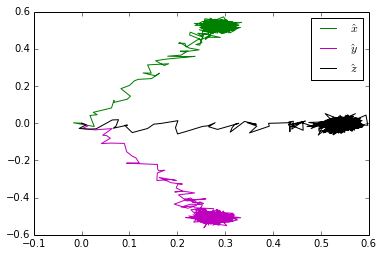

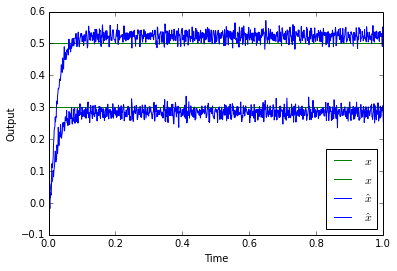

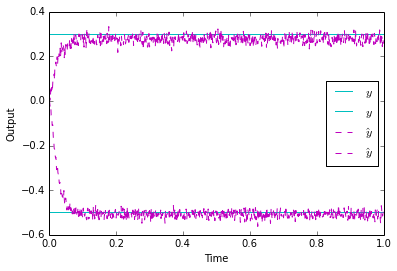

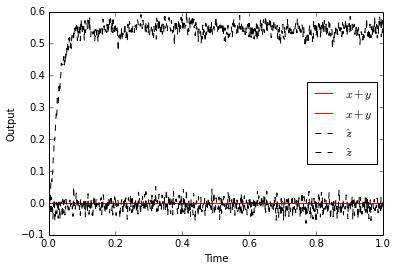

In [17]:
import nengo
from nengo.processes import WhiteNoise
from nengo.utils.matplotlib import rasterplot

T = 1.0
max_freq = 5

model = nengo.Network()

with model:
    #stimA = nengo.Node(output=WhiteSignal(T, high=max_freq, rms=0.3, seed=3), size_out=2)
    #stimB = nengo.Node(output=WhiteSignal(T, high=max_freq, rms=0.3, seed=5), size_out=2)
    
    stimA = nengo.Node([.3,.5])
    stimB = nengo.Node([.3,-.5])
    
    ensA = nengo.Ensemble(55, dimensions=2)
    ensB = nengo.Ensemble(53, dimensions=2)
    ensC = nengo.Ensemble(54, dimensions=2)
    
    nengo.Connection(stimA, ensA)
    nengo.Connection(stimB, ensB)
    nengo.Connection(ensA, ensC)
    nengo.Connection(ensB, ensC)
    
    stimA_p = nengo.Probe(stimA)
    stimB_p = nengo.Probe(stimB)
    ensA_p = nengo.Probe(ensA, synapse=.02)
    ensB_p = nengo.Probe(ensB, synapse=.02)
    ensC_p = nengo.Probe(ensC, synapse=.02)
   
sim = nengo.Simulator(model)
sim.run(T)

figure()
plot(sim.data[ensA_p][:,0], sim.data[ensA_p][:,1], 'g', label="$\hat{x}$")
plot(sim.data[ensB_p][:,0], sim.data[ensB_p][:,1], 'm', label="$\hat{y}$")
plot(sim.data[ensC_p][:,0], sim.data[ensC_p][:,1], 'k', label="$\hat{z}$")
legend(loc='best')

figure()
plot(t, sim.data[stimA_p],'g', label="$x$")
plot(t, sim.data[ensA_p],'b', label="$\hat{x}$")
legend(loc='best')
ylabel("Output")
xlabel("Time")

figure()
plot(t, sim.data[stimB_p],'c', label="$y$")
plot(t, sim.data[ensB_p],'m--', label="$\hat{y}$")
legend(loc='best')
ylabel("Output")
xlabel("Time")

figure()
plot(t, sim.data[stimB_p]+sim.data[stimA_p],'r', label="$x+y$")
plot(t, sim.data[ensC_p],'k--', label="$\hat{z}$")
legend(loc='best')
ylabel("Output")
xlabel("Time");

### Summary

- We can use the decoders to find connection weights between groups of neurons
    - $\omega_{ij}=\alpha_j e_j \cdot d_i$
- Using connection weights is numerically identical to decoding and then encoding again
    - Which can be much more efficient to implement
- Feeding two inputs into the same population results in addition
- These shortcuts rely on two assumptions:
    - The input to a neuron is a weighted sum of its synaptic inputs
        - $J_j = \sum_i a_i \omega_{ij}$
    - The mapping from $x$ to $J$ is of the form $J_j=\alpha_j e_j \cdot x + J_j^{bias}$
- If these assumptions don't hold, you have to do some other form of optimization    

- If you already have a decoder for $x$, you can quickly find a decoder for any linear function of $x$
    - If the decoder for $x$ is $d$, the decoder for $Mx$ is $Md$
- For some other function of $x$, substitute in that function $f(x)$ when finding $\Upsilon$
- Taking all of this into account, the most general form of the weights is:
    -  $\omega_{ij} = e_j M d_i^{f(x)}$

### A recipe
- To find weights for any linear transformation
    1. Define the repn (enc/dec) for all variables involved in the operation.
    2. Write the transformation in terms of these variables.
    3. Write the transformation using the decoding expressions for all variables except the output variable. 
    4. Substitute this expression into the encoding expression of the output variable.
    
    
- Volunteer for:
    - $z = x+y$
    - $z = Rx$
        - R is a 2D rotation matrix: $$\left[ \begin{array}{cc}
              \cos \theta & \sin \theta \\
              -\sin \theta & \cos \theta
              \end{array} \right]$$

    - $z = x \times y$

###General nonlinear functions

- What if we want to combine to compute a nonlinear function of two inputs?
    - E.g., $z=x \times y$
- We know how to compute nonlinear functions of a vector space
    - E.g., $x^2$
    - If $x$ is a vector, you get a bunch of cross terms
    - E.g. if $x$ is 2D this gives $x_1^2 + 2 x_1 x_2 + x_2^2$
- This means that if you combine two inputs into a 2D space, you can get out their product

Simulation finished in 0:00:01.                                                 


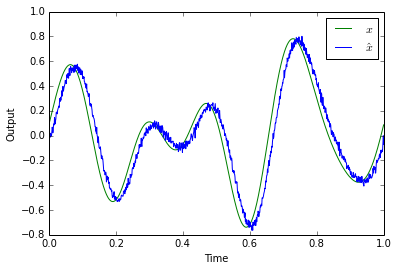

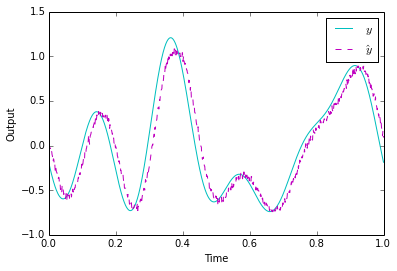

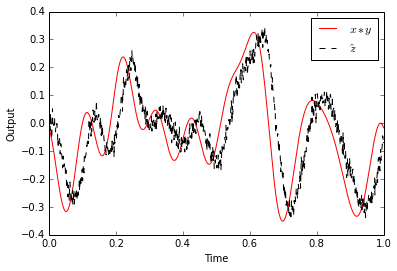

In [18]:
import nengo
from nengo.processes import WhiteNoise
from nengo.utils.matplotlib import rasterplot

T = 1.0
max_freq = 5

model = nengo.Network()

with model:
    stimA = nengo.Node(output=WhiteSignal(T, high=max_freq, rms=0.5, seed=3))
    stimB = nengo.Node(output=WhiteSignal(T, high=max_freq, rms=0.5, seed=5))
    
    ensA = nengo.Ensemble(55, dimensions=1)
    ensB = nengo.Ensemble(53, dimensions=1)
    ensC = nengo.Ensemble(200, dimensions=2)
    ensD = nengo.Ensemble(54, dimensions=1)
    
    nengo.Connection(stimA, ensA)
    nengo.Connection(stimB, ensB)
    nengo.Connection(ensA, ensC, transform=[[1],[0]])
    nengo.Connection(ensB, ensC, transform=[[0],[1]])
    nengo.Connection(ensC, ensD, function=lambda x: x[0]*x[1])
    
    stimA_p = nengo.Probe(stimA)
    stimB_p = nengo.Probe(stimB)
    ensA_p = nengo.Probe(ensA, synapse=.01)
    ensB_p = nengo.Probe(ensB, synapse=.01)
    ensC_p = nengo.Probe(ensC, synapse=.01)
    ensD_p = nengo.Probe(ensD, synapse=.01)
   
sim = nengo.Simulator(model)
sim.run(T)

figure()
plot(t, sim.data[stimA_p],'g', label="$x$")
plot(t, sim.data[ensA_p],'b', label="$\hat{x}$")
legend(loc='best')
ylabel("Output")
xlabel("Time")

figure()
plot(t, sim.data[stimB_p],'c', label="$y$")
plot(t, sim.data[ensB_p],'m--', label="$\hat{y}$")
legend(loc='best')
ylabel("Output")
xlabel("Time")

figure()
plot(t, sim.data[stimB_p]*sim.data[stimA_p],'r', label="$x * y$")
plot(t, sim.data[ensD_p],'k--', label="$\hat{z}$")
legend(loc='best')
ylabel("Output")
xlabel("Time");

- Multiplication is quite powerful, and has lots of uses
    - Gating of signals
    - Attention effects
    - Binding
    - Statistical inference
    
- Here's a simple gating example using the same network

Simulation finished in 0:00:01.                                                 


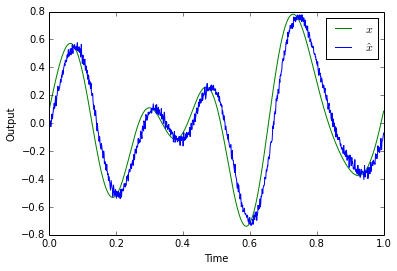

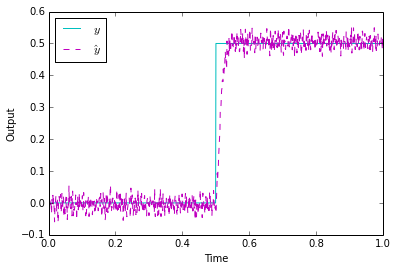

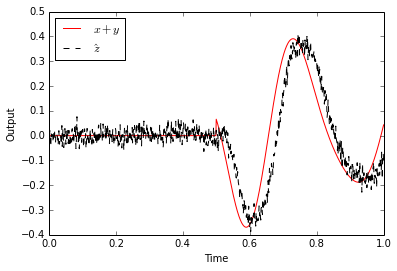

In [19]:
with model:
    stimB.output = lambda t: 0 if (t<.5) else .5
    
sim = nengo.Simulator(model)
sim.run(T)

figure()
plot(t, sim.data[stimA_p],'g', label="$x$")
plot(t, sim.data[ensA_p],'b', label="$\hat{x}$")
legend(loc='best')
ylabel("Output")
xlabel("Time")

figure()
plot(t, sim.data[stimB_p],'c', label="$y$")
plot(t, sim.data[ensB_p],'m--', label="$\hat{y}$")
legend(loc='best')
ylabel("Output")
xlabel("Time")

figure()
plot(t, sim.data[stimB_p]*sim.data[stimA_p],'r', label="$x+y$")
plot(t, sim.data[ensD_p],'k--', label="$\hat{z}$")
legend(loc='best')
ylabel("Output")
xlabel("Time");